In [2]:
from scipy.io import loadmat
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_digits

## 1 Pseudoinverse

### Problem 1.1

Since $A^\top A \mathbf{w} = A^\top \mathbf{b}$, and $A = USV^\top$ we have
$$
A^\top A \mathbf{w} =VS^\top U^\top USV^\top\mathbf{w} = VSSV^\top\mathbf{w} = VS^\top U^\top\mathbf{b}
$$
which means 

$$
V^\top\mathbf{w} = S^{-1}U^\top\mathbf{b}.
$$

### Problem 1.2

Since 
$$
A^\dagger \mathbf{b} = A^\dagger AA^\dagger b = (A^\dagger A)^\top A^\dagger b = A^\top {A^\top}^\dagger A^\dagger \mathbf{b} = A^\top({A^\top}^\dagger A^\dagger \mathbf{b})
$$
we can see that $A^\dagger \mathbf{b}$ is in the row space of $A$.
And from the previous problem, we have found that $A^\dagger \mathbf{b}$ satifies Equation (1).

### Problem 1.3

Assume that $\mathbf{q} = A^\top\mathbf{w}$, where $\mathbf{q} \neq A^\dagger \mathbf{b}$. 

Since $\mathbf{q}$ also satisfies Equation (1), we have
$$
V^\top \mathbf{q} = S^{-1}U^\top\mathbf{b},
$$
i.e.
$$
\mathbf{q} = VS^{-1}U^\top\mathbf{b} = A^\dagger \mathbf{b}.
$$
It contradicts to our assumption. Hence, it cannot exist another vector $\mathbf{q}$.

Since the minimum Euclidean norm solution must be in the row space of $A$, and except $A^\dagger\mathbf{b}$, all vectors in the row space of $A$ cannot satisfy Equation (1), which means that they cannot satisfy the normal equations. Hence $A^\dagger\mathbf{b}$ is the minimum Euclidean norm solution to the normal equations.

## 2 Low-rank approximation

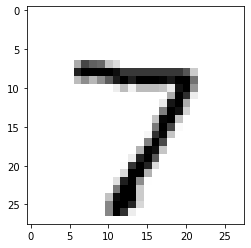

In [12]:
A = loadmat('ocr.mat')['testdata']
plt.imshow(A[0].reshape((28,28)), cmap=cm.gray_r)
plt.show()

### Problem 2.1

In the first way, the minimum value of the objective $J$ is 

In [15]:
tU, tD, tVT = np.linalg.svd(A)
np.linalg.norm(A - tD[0]*tU[:,0].reshape(-1,1)@tVT[0].reshape(1,-1))**2/(10000 * 784)

4122.1219072542135

In the second way, the minimum value of the objective $J$ is

In [4]:
U, D, VT = np.linalg.svd(A)
J = 0
for i in range(1, D.shape[0]):
    J += D[i] ** 2
print(J/(10000*784))

4122.121907254215


We can see that they are the same.

### Problem 2.2

In [5]:
def gd(params, lr):
    for param in params:
        param.data -= lr * param.grad
        #print(param.grad)

In [6]:
def loss(A, b, c):
    return torch.linalg.matrix_norm(A - b@c) ** 2 / (10000 * 784)

In [7]:
b = torch.ones((10000, 1), dtype=torch.float32, requires_grad=True)
c = torch.ones((1, 784), dtype=torch.float32, requires_grad=True)
iterations = 250
step_size = 1

train_l = []
train_l.append(loss(torch.tensor(A), b, c).item())
for it in range(iterations):
    l = loss(torch.tensor(A), b, c)
    l.backward()
    gd([b, c], step_size)
    b.grad.data.zero_()
    c.grad.data.zero_()
    train_l.append(loss(torch.tensor(A), b, c).item())
target = train_l[-1]

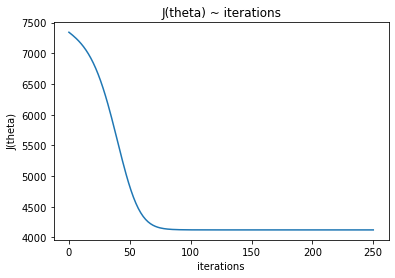

In [8]:
plt.plot(train_l);
plt.title('J(theta) ~ iterations');
plt.xlabel('iterations');
plt.ylabel('J(theta)');

In [9]:
print(f'The final object value is {target}')

The final object value is 4122.1220703125


### Problem 2.3

In [10]:
b = torch.ones((10000, 1), dtype=torch.float32, requires_grad=True)
c = torch.ones((1, 784), dtype=torch.float32, requires_grad=True)
iterations = 250
step_size = 7

train_l = []
train_l.append(loss(torch.tensor(A), b, c).item())
#print('number of iteration: %d, J = %f' % (0, train_l[-1]))
for it in range(iterations):
    l = loss(torch.tensor(A), b, c)
    l.backward()
    gd([b, c], step_size)
    b.grad.data.zero_()
    c.grad.data.zero_()
    train_l.append(loss(torch.tensor(A), b, c).item())
    #print('number of iteration: %d, J = %f' % (it + 1, train_l[-1]))
    if train_l[-1] == target:
        break

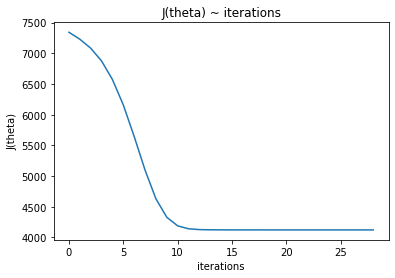

In [11]:
plt.plot(train_l);
plt.title('J(theta) ~ iterations');
plt.xlabel('iterations');
plt.ylabel('J(theta)');

In [12]:
print(f'The step size I try is 7. {it+1} iterations are needed.')

The step size I try is 7. 28 iterations are needed.


### Problem 2.4

Let $M = A-\mathbf{b}\mathbf{c}^\top$, we have 
$$
\begin{aligned}
\frac{\partial J}{\partial \mathbf{b}} &= \frac{1}{nd}\frac{\partial \text{tr}(MM^\top)}{\partial \mathbf{b}} \\
&= \frac{1}{nd}  \frac{\partial \text{tr}(MM^\top)}{\partial M}(\frac{\partial M}{\partial \mathbf{b}})^\top  \\
&= -\frac{2}{nd} M\mathbf{c},
\end{aligned}
$$
we have 
$$
\mathbf{b}_* = \frac{A\mathbf{c}}{\left\lVert \mathbf{c}\right\rVert_2^2}.
$$

### Problem 2.5

Similar to 2.4, we have 
$$
\mathbf{c}_* = \frac{A^\top\mathbf{b}}{\left\lVert \mathbf{b}\right\rVert_2^2}.
$$

### Problem 2.6

In [13]:
b = np.ones((10000,1))
c = np.ones((784,1))
train_l = []
train_l.append((np.linalg.norm(A-b@np.transpose(c))**2)/(10000 * 784))
#print('number of iteration: %d, J = %f' % (0, train_l[-1]))
for it in range(5):
    b = A @ c / (np.linalg.norm(c)**2)
    c = np.transpose(A) @ b / (np.linalg.norm(b)**2)
    train_l.append((np.linalg.norm(A-b@np.transpose(c))**2)/(10000 * 784))
    #print('number of iteration: %d, J = %f' % (it + 1, train_l[-1]))

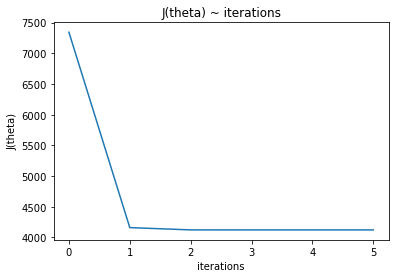

In [14]:
plt.plot(train_l);
plt.title('J(theta) ~ iterations');
plt.xlabel('iterations');
plt.ylabel('J(theta)');

### Problem 2.7

Let $N = A-BC$, we have 
$$
\begin{aligned}
\frac{\partial J}{\partial C} &= \frac{\partial \text{tr}(NN^\top)}{\partial C} \\
&= \frac{\partial \text{tr}(NN^\top)}{\partial N^\top} \frac{\partial N^\top}{\partial C} \\
&= -2N^\top B \\
&= -2(A^\top B - C^\top B^\top B)
\end{aligned}
$$

Hence, when $C_* = (B^\top B)^{-1}B^\top A$, $J(B, C)$ has the minimum value. It is easy to verify that $A-BC_* = \mathbf{0}$.

### Problem 2.8

Let $b_i$ be the index of 1 in column $i$ of $B$. Let $\mathbf{a}_i$ be the $i$th column vector of $A$. Let $\mathbf{c}_i$ be the $i$th column vector of $C$. We have

$$
{\left\lVert A - BC\right\rVert_F^2} = \sum_{i=1}^n {\left\lVert \mathbf{a}_i - \mathbf{c}_{b_i}\right\rVert_2^2}.
$$

Hence, ${\left\lVert \mathbf{a}_i - \mathbf{c}_{b_i}\right\rVert_2^2}$ should be as small as possible to minimize the objective function.

### Problem 2.9

In [15]:
n = A.shape[0]
def train(k):
    C = np.split(A, [k])[0]
    loss = []
    while len(loss) < 2 or abs(loss[-1] - loss[-2]) > 0.001:
        # update B
        B = np.zeros((n, k))
        for i in range(n):
            min_val = np.linalg.norm(A[i] - C[0])
            min_idx = 0
            for j in range(k):
                if min_val > np.linalg.norm(A[i] - C[j]):
                    min_val = np.linalg.norm(A[i] - C[j])
                    min_idx = j
            B[i][min_idx] = 1
        # update C
        C = (np.linalg.inv((np.transpose(B)@B)))@np.transpose(B)@A
        loss.append((np.linalg.norm(A-B@C))**2)
        #print(loss[-1])
    return loss, C

In [16]:
l, c = train(20)

In [17]:
print(f'{len(l)} iterations are required. The final object value is {l[-1]}.')

66 iterations are required. The final object value is 22650694292.207085.


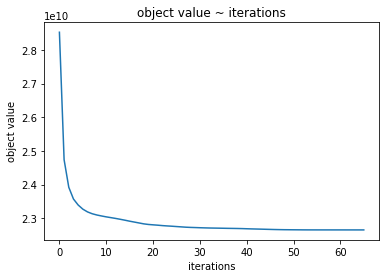

In [18]:
plt.plot(l);
plt.title('object value ~ iterations');
plt.xlabel('iterations');
plt.ylabel('object value');

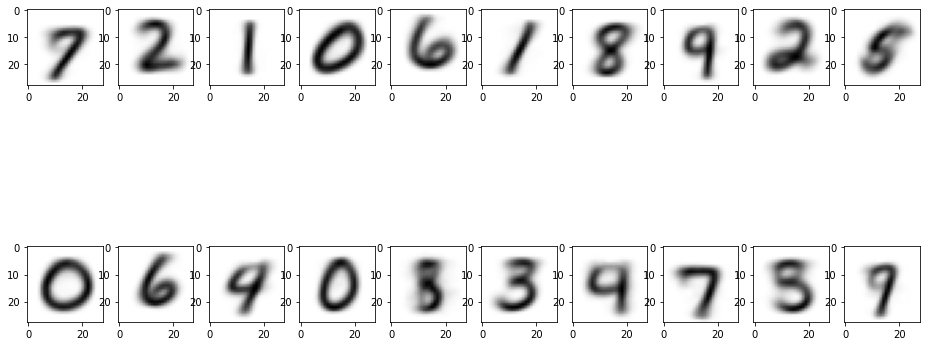

In [19]:
fig, ax = plt.subplots(2, 10, figsize=(16,8))
for i in range(20):
    ax[i//10][i%10].imshow(c[i].reshape((28,28)), cmap=cm.gray_r)

It does seems like alll 10 digits are represented.

### Problem 2.10

In [20]:
#n = A.shape[0]
l, c = train(10)

In [21]:
print(f'{len(l)} iterations are required. The final object value is {l[-1]}.')

63 iterations are required. The final object value is 25377489886.14594.


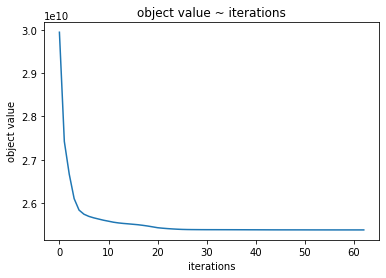

In [22]:
plt.plot(l);
plt.title('object value ~ iterations');
plt.xlabel('iterations');
plt.ylabel('object value');

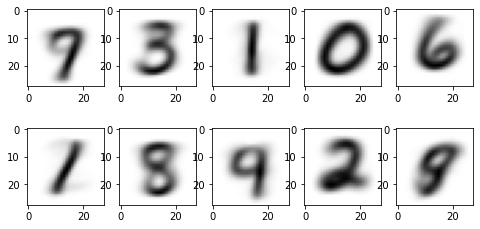

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(8,4))
for i in range(10):
    ax[i//5][i%5].imshow(c[i].reshape((28,28)), cmap=cm.gray_r)

It does seems like all 10 digits are represented. The middle plot of the second line is similar to 9 and 4. The right plot of the second line is similar to 5.

## 3 Neural networks

In [4]:
class OneLayerNet(nn.Module):
    def __init__(self, n_input, n_output):
        super(OneLayerNet, self).__init__()
        self.linear = nn.Linear(n_input, n_output)

    def forward(self, x):
        x = self.linear(x)
        return x

class TwoLayerNet(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(n_input, n_hidden)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class ThreeLayerNet(nn.Module):
    def __init__(self, n_input, n_output, n_hidden1, n_hidden2):
        super(ThreeLayerNet, self).__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(n_input, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, n_output)
        
    def forward(self, x):
        x = self.linear1(x.view(x.shape[0], -1))
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

def XOR_data():
    X = torch.tensor([[-1., -1.], [1., -1.], [-1., 1.], [1., 1.]])
    Y = (torch.prod(X, dim=1) < 0.).float()
    return X, Y.view(-1,1)

def digits_data():
    digits, labels = load_digits(return_X_y=True)
    digits = torch.tensor(digits.reshape([-1, 8, 8]), dtype=torch.float)
    labels = torch.tensor(labels.reshape([-1, 1]) % 2 == 1, dtype=torch.float)
    test_digits = digits[:180,:,:]
    test_labels = labels[:180]
    digits = digits[180:,:,:]
    labels = labels[180:]
    return digits, labels, test_digits, test_labels

def gradient_descent(net, X, Y, num_iterations, eta):
    objective_fn = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        objective_values = [ objective_fn(net(X), Y).item() ]
        error_rates = [ error_rate(net(X), Y).item() ]
    for _ in range(num_iterations):
        output = objective_fn(net(X), Y)
        output.backward()
        for param in net.parameters():
            param.data -= eta * param.grad
            param.grad.data.zero_()
        objective_values.append(objective_fn(net(X), Y).item())
        error_rates.append(error_rate(net(X), Y).item())
    return objective_values, error_rates

def gradient_descent_33(net, X, Y, num_iterations, eta, test_digits, test_labels):
    objective_fn = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        objective_values = [ objective_fn(net(X), Y).item() ]
        error_rates = [ error_rate(net(X), Y).item() ]
        test_error_rate = [ error_rate(net(test_digits), test_labels).item() ]
    for _ in range(num_iterations):
        output = objective_fn(net(X), Y)
        output.backward()
        for param in net.parameters():
            param.data -= eta * param.grad
            param.grad.data.zero_()
        objective_values.append(objective_fn(net(X), Y).item())
        error_rates.append(error_rate(net(X), Y).item())
        test_error_rate.append(error_rate(net(test_digits), test_labels).item())
    return objective_values, error_rates, test_error_rate

def error_rate(Yhat, Y):
    return ((torch.sign(Yhat) > 0).float() != Y).float().mean()

if __name__ == '__main__':
    XOR_X, XOR_Y = XOR_data()
    digits, labels, test_digits, test_labels = digits_data()
    in_features, out_features = XOR_X.shape[1], XOR_Y.shape[1]
    
    num_iterations = 25
    eta = 1.0

    torch.manual_seed(0)
    net1 = OneLayerNet(in_features, out_features)
    #nn.init.normal_(net1.linear.weight, mean=0, std=0.1)
    #nn.init.constant_(net1.linear.bias, val=0)
    objective_values_net1, error_rates_net1 = gradient_descent(net1, XOR_X, XOR_Y, num_iterations, eta)
    
    torch.manual_seed(0)
    net2 = TwoLayerNet(in_features, out_features, 2)
    #nn.init.normal_(net2.linear1.weight, mean=0, std=0.1)
    #nn.init.constant_(net2.linear1.bias, val=0)
    #nn.init.normal_(net2.linear2.weight, mean=0, std=0.1)
    #nn.init.constant_(net2.linear2.bias, val=0)
    objective_values_net2, error_rates_net2 = gradient_descent(net2, XOR_X, XOR_Y, num_iterations, eta)
    
    num_iterations = 500
    eta = 0.1

    torch.manual_seed(0)
    net3 = ThreeLayerNet(64, labels.shape[1], 64, 32)
    #nn.init.normal_(net3.linear1.weight, mean=0, std=0.1)
    #nn.init.constant_(net3.linear1.bias, val=0)
    #nn.init.normal_(net3.linear2.weight, mean=0, std=0.1)
    #nn.init.constant_(net3.linear2.bias, val=0)
    #nn.init.normal_(net3.linear3.weight, mean=0, std=0.1)
    #nn.init.constant_(net3.linear3.bias, val=0)
    objective_values_net3, error_rates_net3, test_error_rate3 = gradient_descent_33(net3, digits, labels, num_iterations, eta, test_digits, test_labels)

### Problem 3.1

In [25]:
print(f'The objective value at initialization is {round(objective_values_net1[0], 6)}.')
print(f'After 25 iterations of gradient descent, the objective value is {round(objective_values_net1[-1], 6)}.')
print(f'The training error rate at initialization is {error_rates_net1[0]}.')
print(f'After 25 iterations of gradient descent, the training error rate is {error_rates_net1[-1]}.')

The objective value at initialization is 0.751374.
After 25 iterations of gradient descent, the objective value is 0.693147.
The training error rate at initialization is 0.5.
After 25 iterations of gradient descent, the training error rate is 0.5.


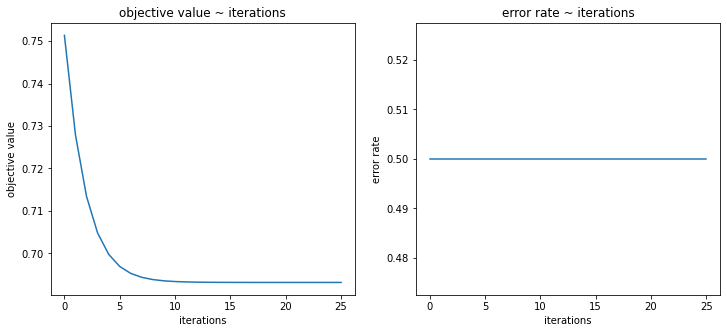

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(objective_values_net1);
ax[0].set_xlabel('iterations');
ax[0].set_ylabel('objective value');
ax[0].set_title('objective value ~ iterations');
ax[1].plot(error_rates_net1);
ax[1].set_xlabel('iterations');
ax[1].set_ylabel('error rate');
ax[1].set_title('error rate ~ iterations');

### Problem 3.2

In [27]:
print(f'The objective value at initialization is {round(objective_values_net2[0], 6)}.')
print(f'After 25 iterations of gradient descent, the objective value is {round(objective_values_net2[-1], 6)}.')
print(f'The training error rate at initialization is {error_rates_net2[0]}.')
print(f'After 25 iterations of gradient descent, the training error rate is {error_rates_net2[-1]}.')

The objective value at initialization is 0.770884.
After 25 iterations of gradient descent, the objective value is 0.547598.
The training error rate at initialization is 0.25.
After 25 iterations of gradient descent, the training error rate is 0.0.


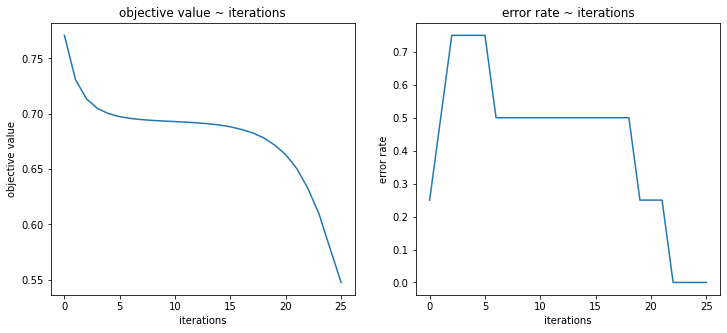

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(objective_values_net2);
ax[0].set_xlabel('iterations');
ax[0].set_ylabel('objective value');
ax[0].set_title('objective value ~ iterations');
ax[1].plot(error_rates_net2);
ax[1].set_xlabel('iterations');
ax[1].set_ylabel('error rate');
ax[1].set_title('error rate ~ iterations');

### Problem 3.3

In [29]:
print(f'The objective value at initialization is {round(objective_values_net3[0], 6)}.')
print(f'After 25 iterations of gradient descent, the objective value is {round(objective_values_net3[-1], 6)}.')
print(f'The training error rate at initialization is {round(error_rates_net3[0], 6)}.')
print(f'After 500 iterations of gradient descent, the training error rate is {error_rates_net3[-1]}.')

The objective value at initialization is 0.768685.
After 25 iterations of gradient descent, the objective value is 0.002583.
The training error rate at initialization is 0.496599.
After 500 iterations of gradient descent, the training error rate is 0.0.


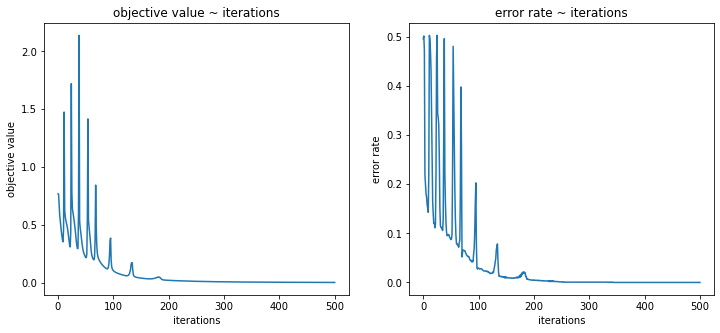

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(objective_values_net3);
ax[0].set_xlabel('iterations');
ax[0].set_ylabel('objective value');
ax[0].set_title('objective value ~ iterations');
ax[1].plot(error_rates_net3);
ax[1].set_xlabel('iterations');
ax[1].set_ylabel('error rate');
ax[1].set_title('error rate ~ iterations');

In [8]:
print(f'The test error rate at initialization is {round(test_error_rate3[0], 6)}.')
print(f'After 500 iterations of gradient descent, the test error rate is {round(test_error_rate3[-1], 6)}.')

The test error rate at initialization is 0.488889.
After 500 iterations of gradient descent, the test error rate is 0.027778.


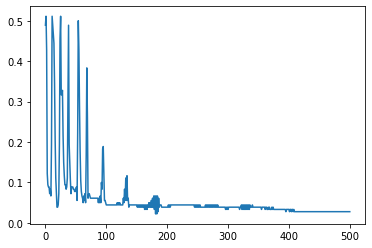

In [9]:
plt.plot(test_error_rate3);